# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from visualize import Visualizer
from metrics import f1_fn, cohen_kappa_fn
from models import PretrainedCNNClassifier
from torch import nn
from optim_utils import build_optimizer_and_scheduler
from torchsummary import summary
from torchvision import transforms
from training import Trainer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")

In [3]:
import gc

def clean_memory():
    gc.collect()
    torch.cuda.empty_cache()

clean_memory()

In [4]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [5]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [6]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

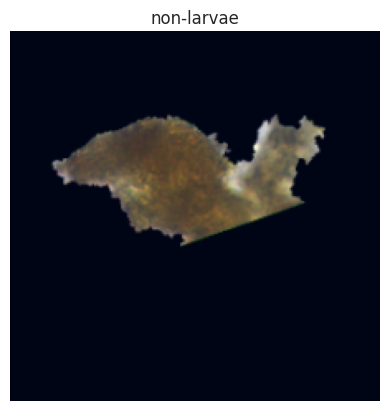

In [7]:
visualize_larvae_sample(train_loader.dataset)

In [8]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(798, 320, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [9]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

optim_config_mlp = {
    "scheduler": "onecycle",
    "max_lr": 2e-4,
    "lr": 1e-4,
    "eta_min": 1e-6,
    "weight_decay": 1e-4,
    "warmup_epochs": 5,
}

optim_config_fine = {
    "scheduler": "onecycle",
    "max_lr": 5e-5,
    "lr": 1e-5,
    "eta_min": 1e-7,
    "weight_decay": 1e-4,
    "warmup_epochs": 5,
}

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [10]:
cnn_0 = PretrainedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    backbone="mobilenet_v2",
    use_dropout=True,
    device=device,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [11]:
ckpt_cnn_0 = "weights/larvae-pre-cnn-0.pt"

#### Train MLP

In [12]:
optimizer_cnn_0, scheduler_cnn_0 = build_optimizer_and_scheduler(
    cnn_0,
    optim_config_mlp,
    train_loader_len=len(train_loader),
    total_epochs=50,
)

trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [13]:
cnn_0.freeze_backbone()
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6583 | Val Loss: 0.6421 | Train cohen_kappa_fn: 0.6303 | Val cohen_kappa_fn: 0.6300 | Train f1_fn: 0.9402 | Val f1_fn: 0.9381
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.5787 | Val Loss: 0.5562 | Train cohen_kappa_fn: 0.6925 | Val cohen_kappa_fn: 0.7409 | Train f1_fn: 0.9461 | Val f1_fn: 0.9545
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.4959 | Val Loss: 0.5019 | Train cohen_kappa_fn: 0.6959 | Val cohen_kappa_fn: 0.7370 | Train f1_fn: 0.9469 | Val f1_fn: 0.9547
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.4185 | Val Loss: 0.4425 | Train cohen_kappa_fn: 0.6773 | Val cohen_kappa_fn: 0.6526 | Train f1_fn: 0.9351 | Val f1_fn: 0.9297
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.3565 | Val Loss: 0.4061 | Train cohen_kappa_fn: 0.6799 | Val cohen_kappa_fn: 0.6381 | Train f1_fn: 0.9370 | Val f1_fn: 0.9255
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.3233 | Val Loss: 0.3785 | Train cohen_kappa_fn: 0.6555 | Val cohen_kappa_fn: 0.6381 | Train f1_fn: 0.9283 | Val f1_fn: 0.9255
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.2890 | Val Loss: 0.3455 | Train cohen_kappa_fn: 0.6653 | Val cohen_kappa_fn: 0.6431 | Train f1_fn: 0.9318 | Val f1_fn: 0.9302
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2716 | Val Loss: 0.3196 | Train cohen_kappa_fn: 0.6642 | Val cohen_kappa_fn: 0.6121 | Train f1_fn: 0.9308 | Val f1_fn: 0.9194
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.2672 | Val Loss: 0.3181 | Train cohen_kappa_fn: 0.6665 | Val cohen_kappa_fn: 0.6211 | Train f1_fn: 0.9327 | Val f1_fn: 0.9240
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.2364 | Val Loss: 0.2941 | Train cohen_kappa_fn: 0.6938 | Val cohen_kappa_fn: 0.6899 | Train f1_fn: 0.9412 | Val f1_fn: 0.9425
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.2305 | Val Loss: 0.2882 | Train cohen_kappa_fn: 0.6608 | Val cohen_kappa_fn: 0.6121 | Train f1_fn: 0.9279 | Val f1_fn: 0.9194
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.2079 | Val Loss: 0.2787 | Train cohen_kappa_fn: 0.7465 | Val cohen_kappa_fn: 0.7149 | Train f1_fn: 0.9532 | Val f1_fn: 0.9486
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.2023 | Val Loss: 0.2885 | Train cohen_kappa_fn: 0.6706 | Val cohen_kappa_fn: 0.6121 | Train f1_fn: 0.9314 | Val f1_fn: 0.9194
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1842 | Val Loss: 0.2766 | Train cohen_kappa_fn: 0.6928 | Val cohen_kappa_fn: 0.6121 | Train f1_fn: 0.9382 | Val f1_fn: 0.9194
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.1695 | Val Loss: 0.2636 | Train cohen_kappa_fn: 0.7305 | Val cohen_kappa_fn: 0.6261 | Train f1_fn: 0.9471 | Val f1_fn: 0.9237
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.1896 | Val Loss: 0.2654 | Train cohen_kappa_fn: 0.7488 | Val cohen_kappa_fn: 0.6706 | Train f1_fn: 0.9521 | Val f1_fn: 0.9362
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1849 | Val Loss: 0.2581 | Train cohen_kappa_fn: 0.7260 | Val cohen_kappa_fn: 0.6211 | Train f1_fn: 0.9474 | Val f1_fn: 0.9240
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2093 | Val Loss: 0.2622 | Train cohen_kappa_fn: 0.7455 | Val cohen_kappa_fn: 0.6052 | Train f1_fn: 0.9513 | Val f1_fn: 0.9173
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1956 | Val Loss: 0.2696 | Train cohen_kappa_fn: 0.7052 | Val cohen_kappa_fn: 0.6507 | Train f1_fn: 0.9415 | Val f1_fn: 0.9323
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1861 | Val Loss: 0.2648 | Train cohen_kappa_fn: 0.7505 | Val cohen_kappa_fn: 0.7498 | Train f1_fn: 0.9549 | Val f1_fn: 0.9565
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1740 | Val Loss: 0.2628 | Train cohen_kappa_fn: 0.6730 | Val cohen_kappa_fn: 0.6121 | Train f1_fn: 0.9333 | Val f1_fn: 0.9194
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1640 | Val Loss: 0.2626 | Train cohen_kappa_fn: 0.7479 | Val cohen_kappa_fn: 0.6981 | Train f1_fn: 0.9531 | Val f1_fn: 0.9446
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


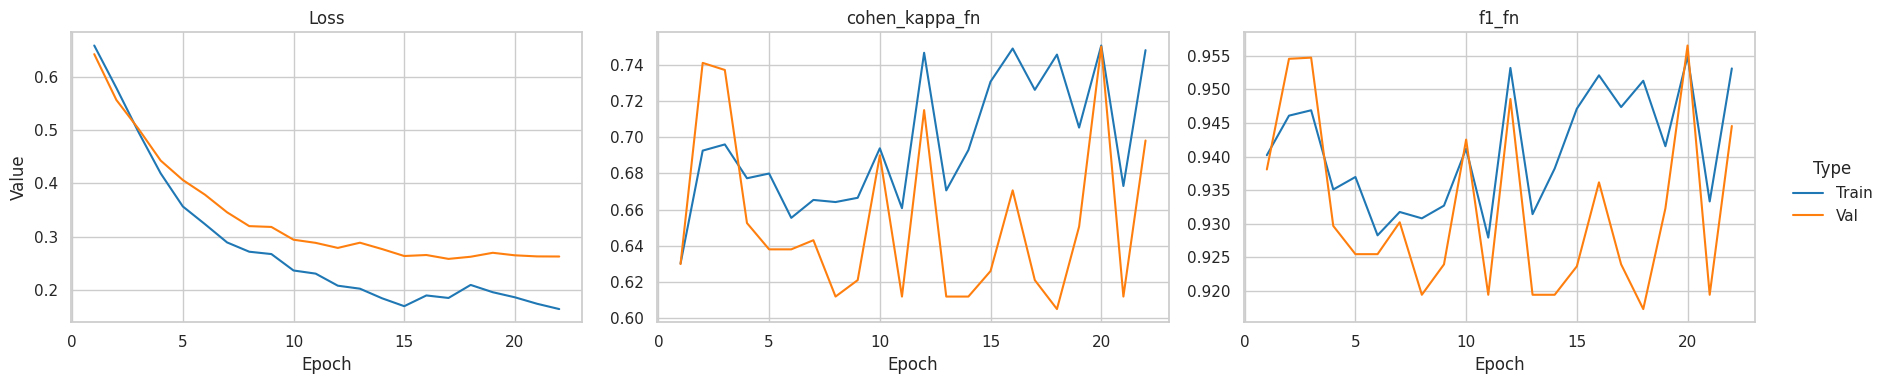

In [14]:
trainer_cnn_0.plot_epochs()

In [15]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2452 | Test cohen_kappa_fn: 0.6140 | Test f1_fn: 0.9168


#### Finetune

In [16]:
optimizer_cnn_0, scheduler_cnn_0 = build_optimizer_and_scheduler(
    cnn_0,
    optim_config_fine,
    train_loader_len=len(train_loader),
    total_epochs=50,
)

trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [17]:
cnn_0.unfreeze_backbone()
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.1769 | Val Loss: 0.2690 | Train cohen_kappa_fn: 0.7666 | Val cohen_kappa_fn: 0.7321 | Train f1_fn: 0.9571 | Val f1_fn: 0.9526
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.1764 | Val Loss: 0.2554 | Train cohen_kappa_fn: 0.7508 | Val cohen_kappa_fn: 0.6751 | Train f1_fn: 0.9530 | Val f1_fn: 0.9359
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.1785 | Val Loss: 0.2681 | Train cohen_kappa_fn: 0.7084 | Val cohen_kappa_fn: 0.6170 | Train f1_fn: 0.9414 | Val f1_fn: 0.9191
  ❄️ No improvement, model won't be saved!


📘 Epoch 4 | Train Loss: 0.1950 | Val Loss: 0.2529 | Train cohen_kappa_fn: 0.7352 | Val cohen_kappa_fn: 0.6600 | Train f1_fn: 0.9479 | Val f1_fn: 0.9318
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.1534 | Val Loss: 0.2351 | Train cohen_kappa_fn: 0.7407 | Val cohen_kappa_fn: 0.7229 | Train f1_fn: 0.9505 | Val f1_fn: 0.9482
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.1837 | Val Loss: 0.2429 | Train cohen_kappa_fn: 0.7115 | Val cohen_kappa_fn: 0.6453 | Train f1_fn: 0.9412 | Val f1_fn: 0.9276
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.1379 | Val Loss: 0.2814 | Train cohen_kappa_fn: 0.6430 | Val cohen_kappa_fn: 0.5228 | Train f1_fn: 0.9219 | Val f1_fn: 0.8834
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.1300 | Val Loss: 0.2325 | Train cohen_kappa_fn: 0.7988 | Val cohen_kappa_fn: 0.7229 | Train f1_fn: 0.9632 | Val f1_fn: 0.9482
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.1417 | Val Loss: 0.2166 | Train cohen_kappa_fn: 0.8388 | Val cohen_kappa_fn: 0.7902 | Train f1_fn: 0.9719 | Val f1_fn: 0.9642
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.1020 | Val Loss: 0.2076 | Train cohen_kappa_fn: 0.7762 | Val cohen_kappa_fn: 0.7313 | Train f1_fn: 0.9585 | Val f1_fn: 0.9502
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.1290 | Val Loss: 0.2084 | Train cohen_kappa_fn: 0.8181 | Val cohen_kappa_fn: 0.7775 | Train f1_fn: 0.9691 | Val f1_fn: 0.9624
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1278 | Val Loss: 0.2013 | Train cohen_kappa_fn: 0.8241 | Val cohen_kappa_fn: 0.7146 | Train f1_fn: 0.9697 | Val f1_fn: 0.9462
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.1066 | Val Loss: 0.1977 | Train cohen_kappa_fn: 0.8625 | Val cohen_kappa_fn: 0.7681 | Train f1_fn: 0.9766 | Val f1_fn: 0.9605
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.1290 | Val Loss: 0.2113 | Train cohen_kappa_fn: 0.7964 | Val cohen_kappa_fn: 0.6381 | Train f1_fn: 0.9634 | Val f1_fn: 0.9255
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1196 | Val Loss: 0.2033 | Train cohen_kappa_fn: 0.8493 | Val cohen_kappa_fn: 0.6706 | Train f1_fn: 0.9734 | Val f1_fn: 0.9362
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1072 | Val Loss: 0.1956 | Train cohen_kappa_fn: 0.8833 | Val cohen_kappa_fn: 0.8192 | Train f1_fn: 0.9814 | Val f1_fn: 0.9700
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.1172 | Val Loss: 0.1945 | Train cohen_kappa_fn: 0.8554 | Val cohen_kappa_fn: 0.7360 | Train f1_fn: 0.9750 | Val f1_fn: 0.9524
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.0975 | Val Loss: 0.2030 | Train cohen_kappa_fn: 0.8806 | Val cohen_kappa_fn: 0.8292 | Train f1_fn: 0.9805 | Val f1_fn: 0.9720
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.0799 | Val Loss: 0.2050 | Train cohen_kappa_fn: 0.8705 | Val cohen_kappa_fn: 0.8265 | Train f1_fn: 0.9781 | Val f1_fn: 0.9721
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1047 | Val Loss: 0.1899 | Train cohen_kappa_fn: 0.8795 | Val cohen_kappa_fn: 0.7189 | Train f1_fn: 0.9797 | Val f1_fn: 0.9484
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.0896 | Val Loss: 0.1975 | Train cohen_kappa_fn: 0.9045 | Val cohen_kappa_fn: 0.7902 | Train f1_fn: 0.9842 | Val f1_fn: 0.9642
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.0815 | Val Loss: 0.1980 | Train cohen_kappa_fn: 0.8927 | Val cohen_kappa_fn: 0.7902 | Train f1_fn: 0.9828 | Val f1_fn: 0.9642
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1093 | Val Loss: 0.1893 | Train cohen_kappa_fn: 0.8954 | Val cohen_kappa_fn: 0.7447 | Train f1_fn: 0.9827 | Val f1_fn: 0.9544
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.0843 | Val Loss: 0.2089 | Train cohen_kappa_fn: 0.8641 | Val cohen_kappa_fn: 0.6863 | Train f1_fn: 0.9765 | Val f1_fn: 0.9403
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.0597 | Val Loss: 0.1958 | Train cohen_kappa_fn: 0.8689 | Val cohen_kappa_fn: 0.6870 | Train f1_fn: 0.9773 | Val f1_fn: 0.9377
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.0861 | Val Loss: 0.1836 | Train cohen_kappa_fn: 0.8673 | Val cohen_kappa_fn: 0.7350 | Train f1_fn: 0.9773 | Val f1_fn: 0.9500
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.0877 | Val Loss: 0.1941 | Train cohen_kappa_fn: 0.8665 | Val cohen_kappa_fn: 0.7146 | Train f1_fn: 0.9774 | Val f1_fn: 0.9462
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.0635 | Val Loss: 0.2005 | Train cohen_kappa_fn: 0.9099 | Val cohen_kappa_fn: 0.6948 | Train f1_fn: 0.9850 | Val f1_fn: 0.9398
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.0863 | Val Loss: 0.1902 | Train cohen_kappa_fn: 0.8891 | Val cohen_kappa_fn: 0.7065 | Train f1_fn: 0.9811 | Val f1_fn: 0.9441
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.0694 | Val Loss: 0.1864 | Train cohen_kappa_fn: 0.8761 | Val cohen_kappa_fn: 0.6751 | Train f1_fn: 0.9789 | Val f1_fn: 0.9359
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.0665 | Val Loss: 0.1825 | Train cohen_kappa_fn: 0.9270 | Val cohen_kappa_fn: 0.7398 | Train f1_fn: 0.9880 | Val f1_fn: 0.9522
  🔥 New best model saved!


📘 Epoch 32 | Train Loss: 0.0653 | Val Loss: 0.1690 | Train cohen_kappa_fn: 0.9480 | Val cohen_kappa_fn: 0.7409 | Train f1_fn: 0.9918 | Val f1_fn: 0.9545
  🔥 New best model saved!


📘 Epoch 33 | Train Loss: 0.0571 | Val Loss: 0.1837 | Train cohen_kappa_fn: 0.9222 | Val cohen_kappa_fn: 0.6981 | Train f1_fn: 0.9873 | Val f1_fn: 0.9446
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.0534 | Val Loss: 0.1670 | Train cohen_kappa_fn: 0.9349 | Val cohen_kappa_fn: 0.7398 | Train f1_fn: 0.9896 | Val f1_fn: 0.9522
  🔥 New best model saved!


📘 Epoch 35 | Train Loss: 0.0687 | Val Loss: 0.1766 | Train cohen_kappa_fn: 0.8967 | Val cohen_kappa_fn: 0.7183 | Train f1_fn: 0.9827 | Val f1_fn: 0.9435
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.0802 | Val Loss: 0.1576 | Train cohen_kappa_fn: 0.9099 | Val cohen_kappa_fn: 0.7224 | Train f1_fn: 0.9850 | Val f1_fn: 0.9457
  🔥 New best model saved!


📘 Epoch 37 | Train Loss: 0.0447 | Val Loss: 0.1842 | Train cohen_kappa_fn: 0.9669 | Val cohen_kappa_fn: 0.7966 | Train f1_fn: 0.9948 | Val f1_fn: 0.9663
  ❄️ No improvement, model won't be saved!


📘 Epoch 38 | Train Loss: 0.0609 | Val Loss: 0.1870 | Train cohen_kappa_fn: 0.9397 | Val cohen_kappa_fn: 0.7498 | Train f1_fn: 0.9903 | Val f1_fn: 0.9565
  ❄️ No improvement, model won't be saved!


📘 Epoch 39 | Train Loss: 0.0616 | Val Loss: 0.1783 | Train cohen_kappa_fn: 0.9353 | Val cohen_kappa_fn: 0.7681 | Train f1_fn: 0.9895 | Val f1_fn: 0.9605
  ❄️ No improvement, model won't be saved!


📘 Epoch 40 | Train Loss: 0.0390 | Val Loss: 0.1804 | Train cohen_kappa_fn: 0.9529 | Val cohen_kappa_fn: 0.7625 | Train f1_fn: 0.9926 | Val f1_fn: 0.9583
  ❄️ No improvement, model won't be saved!


📘 Epoch 41 | Train Loss: 0.0388 | Val Loss: 0.1755 | Train cohen_kappa_fn: 0.9712 | Val cohen_kappa_fn: 0.8064 | Train f1_fn: 0.9956 | Val f1_fn: 0.9682
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


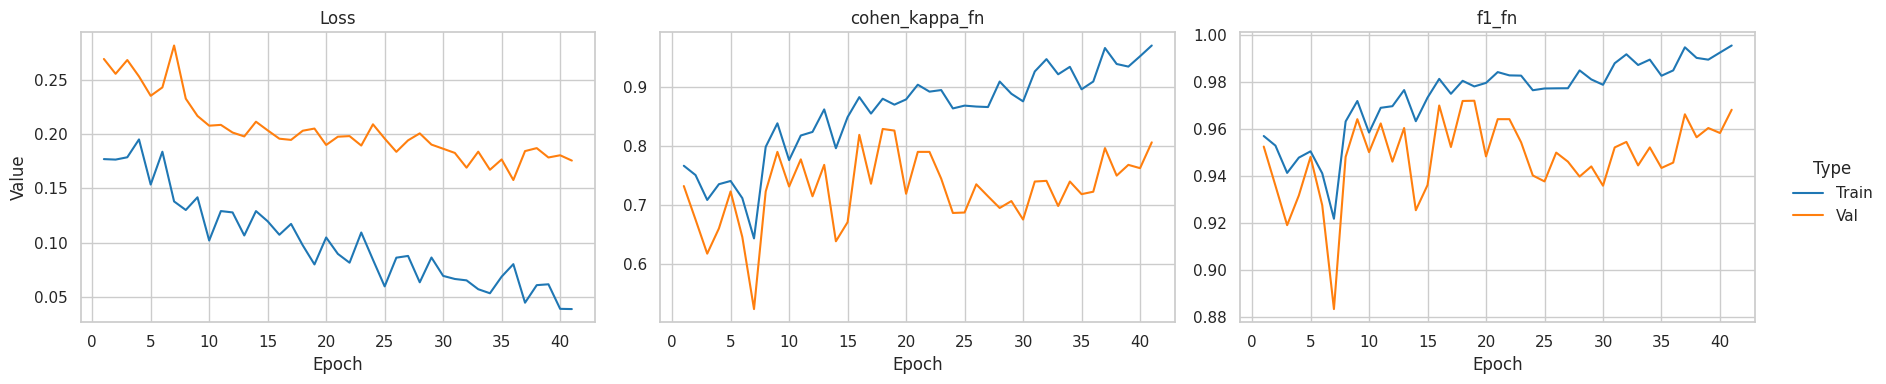

In [18]:
trainer_cnn_0.plot_epochs()

In [19]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1439 | Test cohen_kappa_fn: 0.7884 | Test f1_fn: 0.9619


#### Visualization

In [20]:
visualizer_0 = Visualizer(model=trainer_cnn_0.model, device=device, labels_map=labels_map)

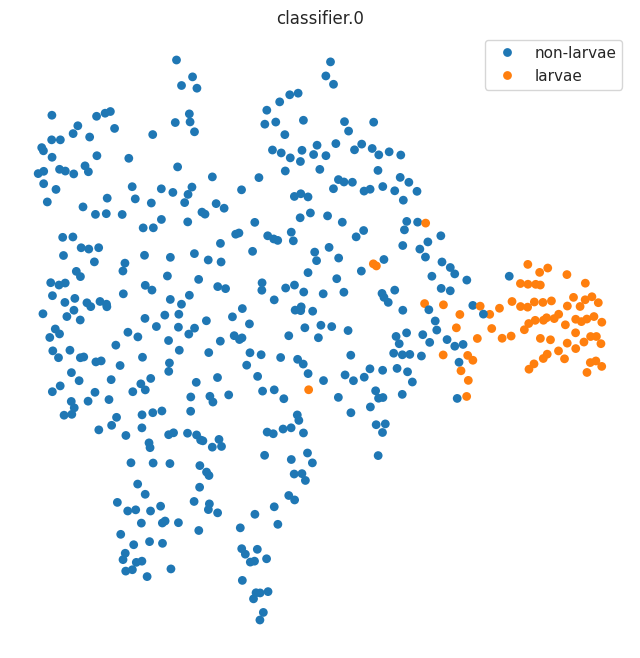

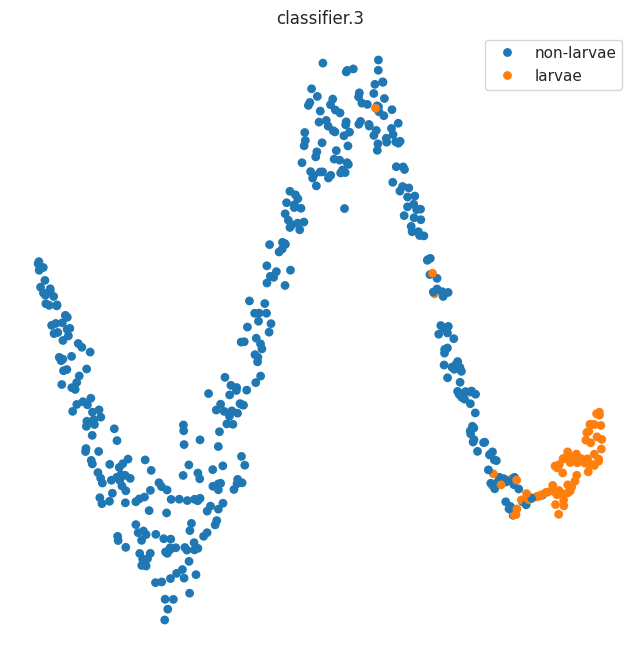

In [21]:
# Display layer representations
visualizer_0.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Larvae!


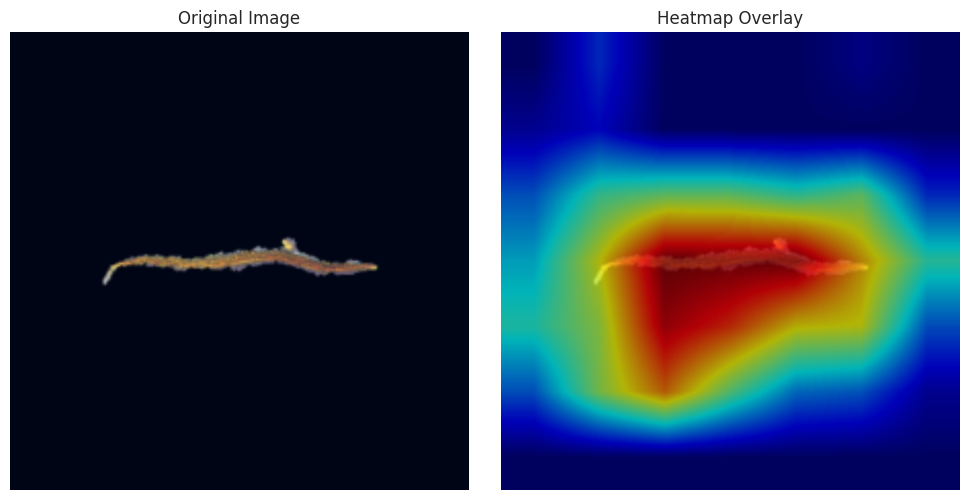

  Generating heatmap for Larvae...
  Predicted label is Larvae!


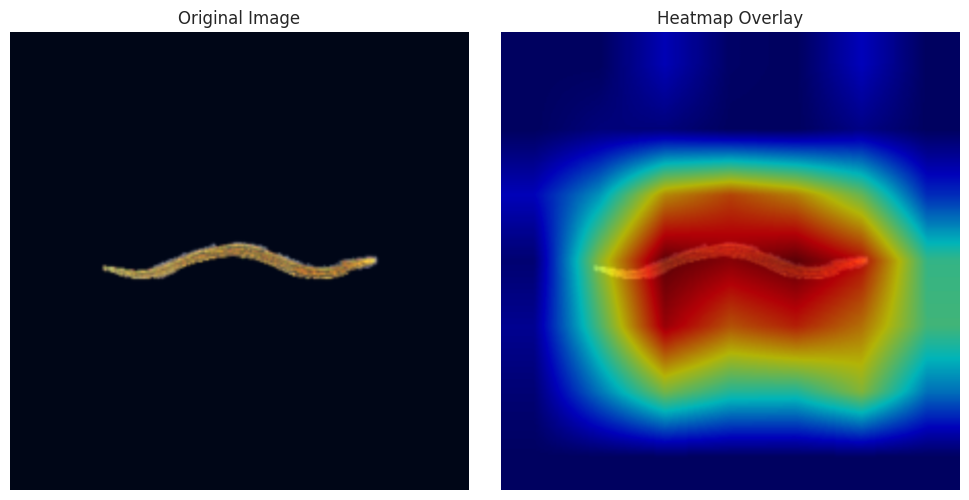

In [22]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.3. CNN1

In [10]:
cnn_1 = PretrainedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    backbone="squeezenet1_0",
    use_dropout=True,
    device=device,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 109, 109]          14,208
              ReLU-2         [-1, 96, 109, 109]               0
         MaxPool2d-3           [-1, 96, 54, 54]               0
            Conv2d-4           [-1, 16, 54, 54]           1,552
              ReLU-5           [-1, 16, 54, 54]               0
            Conv2d-6           [-1, 64, 54, 54]           1,088
              ReLU-7           [-1, 64, 54, 54]               0
            Conv2d-8           [-1, 64, 54, 54]           9,280
              ReLU-9           [-1, 64, 54, 54]               0
             Fire-10          [-1, 128, 54, 54]               0
           Conv2d-11           [-1, 16, 54, 54]           2,064
             ReLU-12           [-1, 16, 54, 54]               0
           Conv2d-13           [-1, 64, 54, 54]           1,088
             ReLU-14           [-1, 64,

In [11]:
ckpt_cnn_1 = "weights/larvae-pre-cnn-1.pt"

#### Train MLP

In [25]:
optimizer_cnn_1, scheduler_cnn_1 = build_optimizer_and_scheduler(
    cnn_1,
    optim_config_mlp,
    train_loader_len=len(train_loader),
    total_epochs=50,
)
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [26]:
cnn_1.freeze_backbone()
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6240 | Val Loss: 0.4507 | Train cohen_kappa_fn: 0.7165 | Val cohen_kappa_fn: 0.7019 | Train f1_fn: 0.9469 | Val f1_fn: 0.9492
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.3658 | Val Loss: 0.3068 | Train cohen_kappa_fn: 0.7575 | Val cohen_kappa_fn: 0.7870 | Train f1_fn: 0.9565 | Val f1_fn: 0.9644
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.2470 | Val Loss: 0.2435 | Train cohen_kappa_fn: 0.7830 | Val cohen_kappa_fn: 0.7870 | Train f1_fn: 0.9611 | Val f1_fn: 0.9644
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.2044 | Val Loss: 0.2056 | Train cohen_kappa_fn: 0.7732 | Val cohen_kappa_fn: 0.8064 | Train f1_fn: 0.9596 | Val f1_fn: 0.9682
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.1760 | Val Loss: 0.2079 | Train cohen_kappa_fn: 0.8220 | Val cohen_kappa_fn: 0.8033 | Train f1_fn: 0.9698 | Val f1_fn: 0.9683
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.1761 | Val Loss: 0.1922 | Train cohen_kappa_fn: 0.7841 | Val cohen_kappa_fn: 0.8292 | Train f1_fn: 0.9620 | Val f1_fn: 0.9720
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.1605 | Val Loss: 0.1865 | Train cohen_kappa_fn: 0.7990 | Val cohen_kappa_fn: 0.8164 | Train f1_fn: 0.9652 | Val f1_fn: 0.9701
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.1488 | Val Loss: 0.1801 | Train cohen_kappa_fn: 0.7915 | Val cohen_kappa_fn: 0.8164 | Train f1_fn: 0.9636 | Val f1_fn: 0.9701
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.1479 | Val Loss: 0.1750 | Train cohen_kappa_fn: 0.8388 | Val cohen_kappa_fn: 0.8164 | Train f1_fn: 0.9729 | Val f1_fn: 0.9701
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.1347 | Val Loss: 0.1653 | Train cohen_kappa_fn: 0.8165 | Val cohen_kappa_fn: 0.8292 | Train f1_fn: 0.9682 | Val f1_fn: 0.9720
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.1344 | Val Loss: 0.1705 | Train cohen_kappa_fn: 0.8447 | Val cohen_kappa_fn: 0.8367 | Train f1_fn: 0.9736 | Val f1_fn: 0.9740
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1349 | Val Loss: 0.1644 | Train cohen_kappa_fn: 0.8074 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9657 | Val f1_fn: 0.9739
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.1194 | Val Loss: 0.1700 | Train cohen_kappa_fn: 0.8241 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9697 | Val f1_fn: 0.9739
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1304 | Val Loss: 0.1646 | Train cohen_kappa_fn: 0.8165 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9682 | Val f1_fn: 0.9739
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1244 | Val Loss: 0.1495 | Train cohen_kappa_fn: 0.8077 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9667 | Val f1_fn: 0.9739
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.1238 | Val Loss: 0.1549 | Train cohen_kappa_fn: 0.8378 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9720 | Val f1_fn: 0.9739
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1081 | Val Loss: 0.1581 | Train cohen_kappa_fn: 0.8738 | Val cohen_kappa_fn: 0.8472 | Train f1_fn: 0.9789 | Val f1_fn: 0.9759
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1118 | Val Loss: 0.1454 | Train cohen_kappa_fn: 0.8447 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9736 | Val f1_fn: 0.9739
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.1245 | Val Loss: 0.1496 | Train cohen_kappa_fn: 0.8625 | Val cohen_kappa_fn: 0.8496 | Train f1_fn: 0.9766 | Val f1_fn: 0.9758
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1105 | Val Loss: 0.1478 | Train cohen_kappa_fn: 0.8496 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9743 | Val f1_fn: 0.9739
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1050 | Val Loss: 0.1363 | Train cohen_kappa_fn: 0.8487 | Val cohen_kappa_fn: 0.8601 | Train f1_fn: 0.9744 | Val f1_fn: 0.9777
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.0954 | Val Loss: 0.1410 | Train cohen_kappa_fn: 0.8681 | Val cohen_kappa_fn: 0.8601 | Train f1_fn: 0.9782 | Val f1_fn: 0.9777
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1047 | Val Loss: 0.1421 | Train cohen_kappa_fn: 0.8665 | Val cohen_kappa_fn: 0.8601 | Train f1_fn: 0.9774 | Val f1_fn: 0.9777
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1005 | Val Loss: 0.1325 | Train cohen_kappa_fn: 0.8689 | Val cohen_kappa_fn: 0.8601 | Train f1_fn: 0.9782 | Val f1_fn: 0.9777
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.0880 | Val Loss: 0.1401 | Train cohen_kappa_fn: 0.8657 | Val cohen_kappa_fn: 0.8601 | Train f1_fn: 0.9774 | Val f1_fn: 0.9777
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.0944 | Val Loss: 0.1300 | Train cohen_kappa_fn: 0.8814 | Val cohen_kappa_fn: 0.8601 | Train f1_fn: 0.9805 | Val f1_fn: 0.9777
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.0977 | Val Loss: 0.1329 | Train cohen_kappa_fn: 0.8576 | Val cohen_kappa_fn: 0.8292 | Train f1_fn: 0.9759 | Val f1_fn: 0.9720
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.0848 | Val Loss: 0.1306 | Train cohen_kappa_fn: 0.8681 | Val cohen_kappa_fn: 0.8707 | Train f1_fn: 0.9782 | Val f1_fn: 0.9796
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.0889 | Val Loss: 0.1258 | Train cohen_kappa_fn: 0.8697 | Val cohen_kappa_fn: 0.8542 | Train f1_fn: 0.9782 | Val f1_fn: 0.9756
  🔥 New best model saved!


📘 Epoch 30 | Train Loss: 0.0882 | Val Loss: 0.1242 | Train cohen_kappa_fn: 0.8828 | Val cohen_kappa_fn: 0.8601 | Train f1_fn: 0.9805 | Val f1_fn: 0.9777
  🔥 New best model saved!


📘 Epoch 31 | Train Loss: 0.0800 | Val Loss: 0.1244 | Train cohen_kappa_fn: 0.9045 | Val cohen_kappa_fn: 0.8542 | Train f1_fn: 0.9842 | Val f1_fn: 0.9756
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.0821 | Val Loss: 0.1254 | Train cohen_kappa_fn: 0.9002 | Val cohen_kappa_fn: 0.8601 | Train f1_fn: 0.9835 | Val f1_fn: 0.9777
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.0756 | Val Loss: 0.1231 | Train cohen_kappa_fn: 0.8919 | Val cohen_kappa_fn: 0.8727 | Train f1_fn: 0.9820 | Val f1_fn: 0.9795
  🔥 New best model saved!


📘 Epoch 34 | Train Loss: 0.0755 | Val Loss: 0.1230 | Train cohen_kappa_fn: 0.9039 | Val cohen_kappa_fn: 0.8727 | Train f1_fn: 0.9843 | Val f1_fn: 0.9795
  🔥 New best model saved!


📘 Epoch 35 | Train Loss: 0.0783 | Val Loss: 0.1252 | Train cohen_kappa_fn: 0.8940 | Val cohen_kappa_fn: 0.8727 | Train f1_fn: 0.9828 | Val f1_fn: 0.9795
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.0799 | Val Loss: 0.1182 | Train cohen_kappa_fn: 0.8836 | Val cohen_kappa_fn: 0.8852 | Train f1_fn: 0.9804 | Val f1_fn: 0.9813
  🔥 New best model saved!


📘 Epoch 37 | Train Loss: 0.0792 | Val Loss: 0.1203 | Train cohen_kappa_fn: 0.8919 | Val cohen_kappa_fn: 0.8852 | Train f1_fn: 0.9820 | Val f1_fn: 0.9813
  ❄️ No improvement, model won't be saved!


📘 Epoch 38 | Train Loss: 0.0784 | Val Loss: 0.1189 | Train cohen_kappa_fn: 0.8967 | Val cohen_kappa_fn: 0.8852 | Train f1_fn: 0.9827 | Val f1_fn: 0.9813
  ❄️ No improvement, model won't be saved!


📘 Epoch 39 | Train Loss: 0.0752 | Val Loss: 0.1182 | Train cohen_kappa_fn: 0.8940 | Val cohen_kappa_fn: 0.8852 | Train f1_fn: 0.9828 | Val f1_fn: 0.9813
  ❄️ No improvement, model won't be saved!


📘 Epoch 40 | Train Loss: 0.0685 | Val Loss: 0.1242 | Train cohen_kappa_fn: 0.9163 | Val cohen_kappa_fn: 0.8942 | Train f1_fn: 0.9866 | Val f1_fn: 0.9833
  ❄️ No improvement, model won't be saved!


📘 Epoch 41 | Train Loss: 0.0847 | Val Loss: 0.1103 | Train cohen_kappa_fn: 0.8729 | Val cohen_kappa_fn: 0.8644 | Train f1_fn: 0.9780 | Val f1_fn: 0.9775
  🔥 New best model saved!


📘 Epoch 42 | Train Loss: 0.0670 | Val Loss: 0.1075 | Train cohen_kappa_fn: 0.9265 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9880 | Val f1_fn: 0.9832
  🔥 New best model saved!


📘 Epoch 43 | Train Loss: 0.0703 | Val Loss: 0.1080 | Train cohen_kappa_fn: 0.9136 | Val cohen_kappa_fn: 0.8852 | Train f1_fn: 0.9857 | Val f1_fn: 0.9813
  ❄️ No improvement, model won't be saved!


📘 Epoch 44 | Train Loss: 0.0760 | Val Loss: 0.1148 | Train cohen_kappa_fn: 0.8996 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9835 | Val f1_fn: 0.9832
  ❄️ No improvement, model won't be saved!


📘 Epoch 45 | Train Loss: 0.0666 | Val Loss: 0.1097 | Train cohen_kappa_fn: 0.9087 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9850 | Val f1_fn: 0.9832
  ❄️ No improvement, model won't be saved!


📘 Epoch 46 | Train Loss: 0.0565 | Val Loss: 0.1131 | Train cohen_kappa_fn: 0.8996 | Val cohen_kappa_fn: 0.9067 | Train f1_fn: 0.9835 | Val f1_fn: 0.9851
  ❄️ No improvement, model won't be saved!


📘 Epoch 47 | Train Loss: 0.0569 | Val Loss: 0.1245 | Train cohen_kappa_fn: 0.9217 | Val cohen_kappa_fn: 0.9052 | Train f1_fn: 0.9873 | Val f1_fn: 0.9852
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


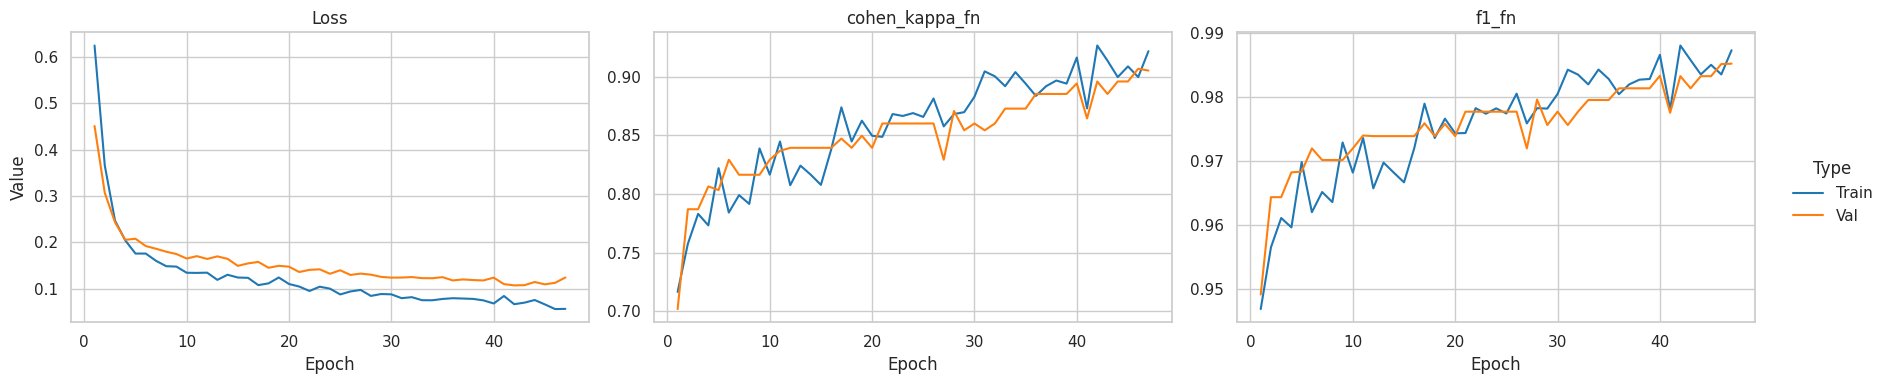

In [27]:
trainer_cnn_1.plot_epochs()

In [28]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.0839 | Test cohen_kappa_fn: 0.9154 | Test f1_fn: 0.9863


#### Finetune

In [12]:
optimizer_cnn_1, scheduler_cnn_1 = build_optimizer_and_scheduler(
    cnn_1,
    optim_config_fine,
    train_loader_len=len(train_loader),
    total_epochs=50,
)
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [30]:
cnn_1.unfreeze_backbone()
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.0770 | Val Loss: 0.1167 | Train cohen_kappa_fn: 0.9093 | Val cohen_kappa_fn: 0.8665 | Train f1_fn: 0.9850 | Val f1_fn: 0.9774
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.0602 | Val Loss: 0.1044 | Train cohen_kappa_fn: 0.9093 | Val cohen_kappa_fn: 0.8852 | Train f1_fn: 0.9850 | Val f1_fn: 0.9813
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.0640 | Val Loss: 0.1211 | Train cohen_kappa_fn: 0.9349 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9896 | Val f1_fn: 0.9832
  ❄️ No improvement, model won't be saved!


📘 Epoch 4 | Train Loss: 0.0500 | Val Loss: 0.1136 | Train cohen_kappa_fn: 0.9401 | Val cohen_kappa_fn: 0.8852 | Train f1_fn: 0.9903 | Val f1_fn: 0.9813
  ❄️ No improvement, model won't be saved!


📘 Epoch 5 | Train Loss: 0.0487 | Val Loss: 0.1150 | Train cohen_kappa_fn: 0.9445 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9910 | Val f1_fn: 0.9832
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.0529 | Val Loss: 0.1084 | Train cohen_kappa_fn: 0.9099 | Val cohen_kappa_fn: 0.8586 | Train f1_fn: 0.9850 | Val f1_fn: 0.9754
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.0453 | Val Loss: 0.1129 | Train cohen_kappa_fn: 0.9580 | Val cohen_kappa_fn: 0.9067 | Train f1_fn: 0.9933 | Val f1_fn: 0.9851
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


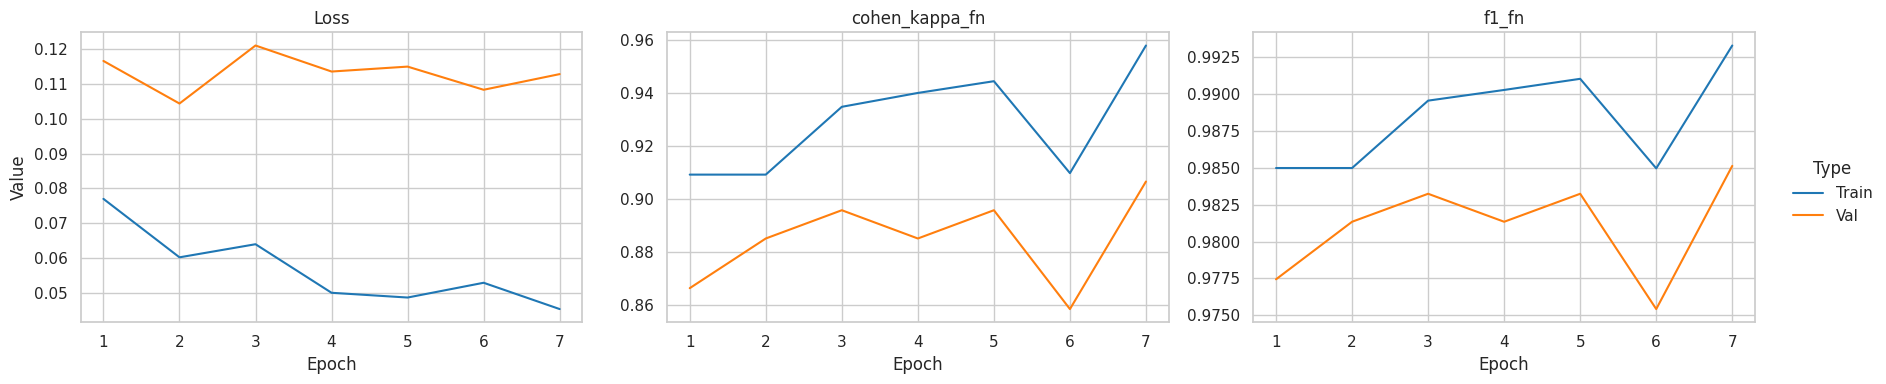

In [31]:
trainer_cnn_1.plot_epochs()

In [13]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.0693 | Test cohen_kappa_fn: 0.9092 | Test f1_fn: 0.9850


#### Visualization

In [14]:
visualizer_1 = Visualizer(model=trainer_cnn_1.model, device=device, labels_map=labels_map)

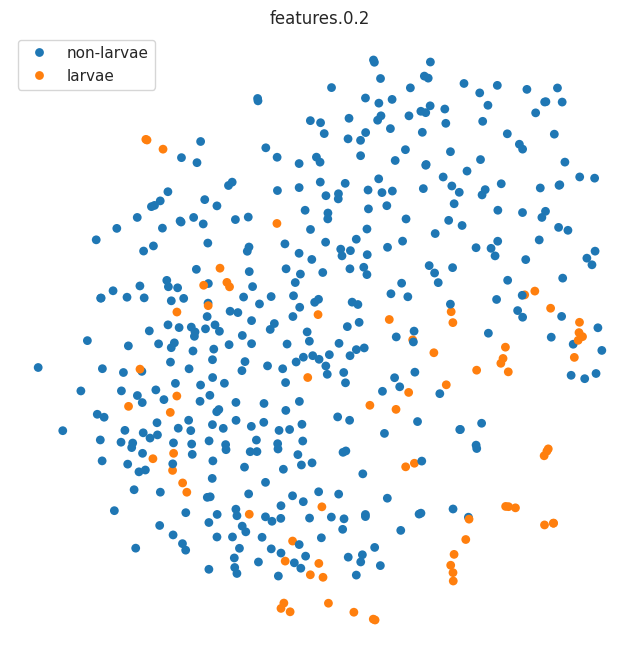

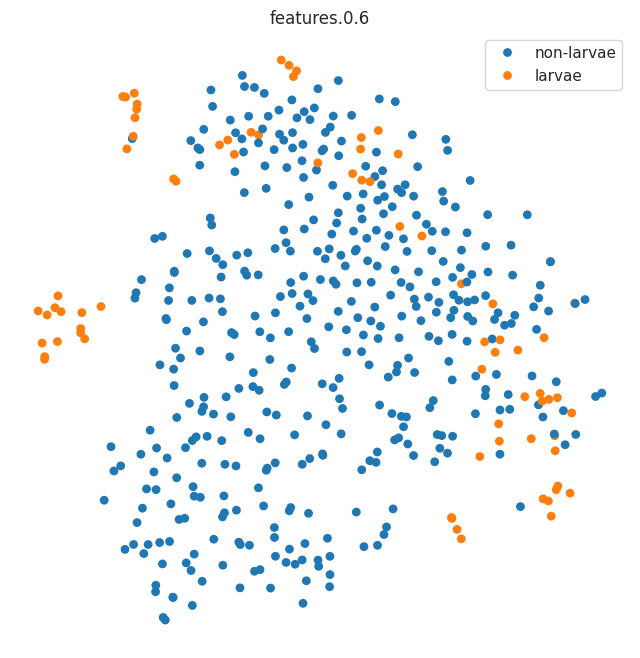

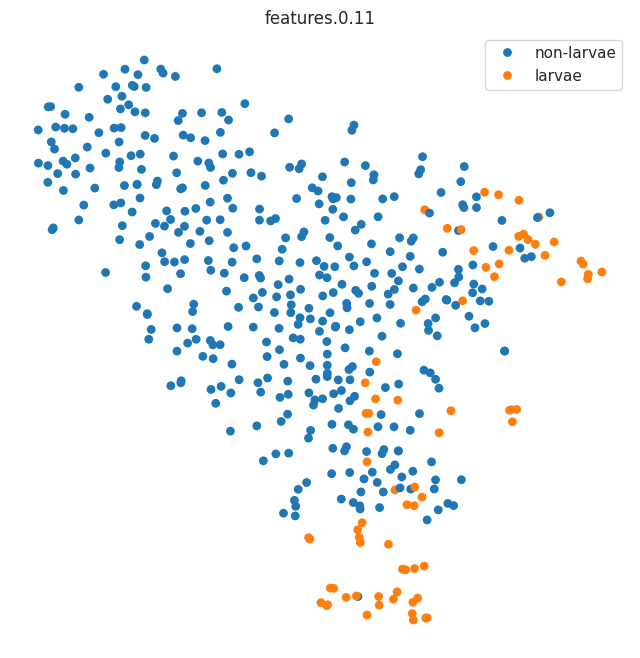

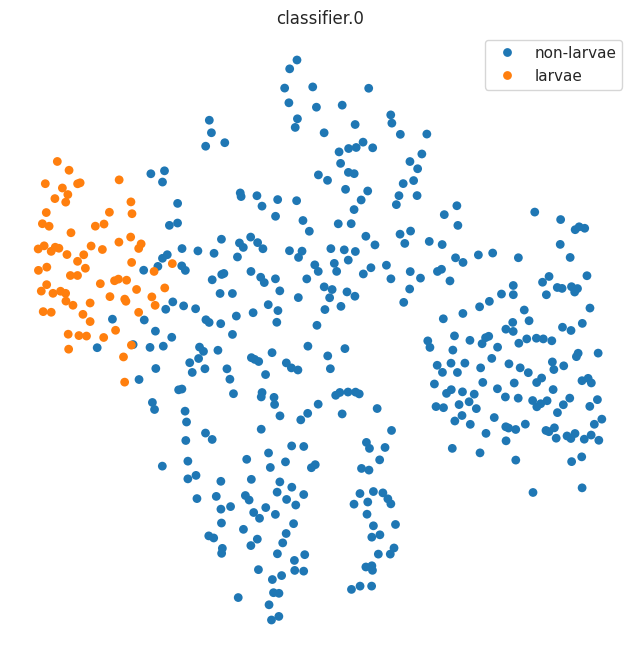

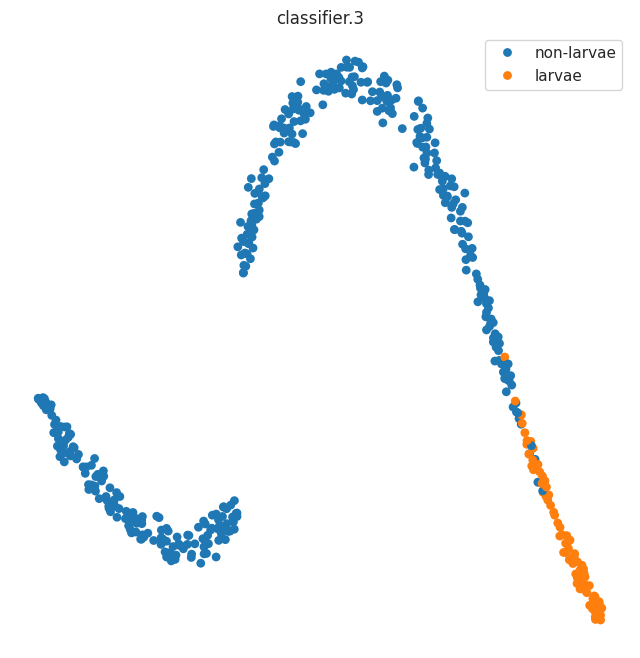

In [15]:
# Display layer representations
visualizer_1.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


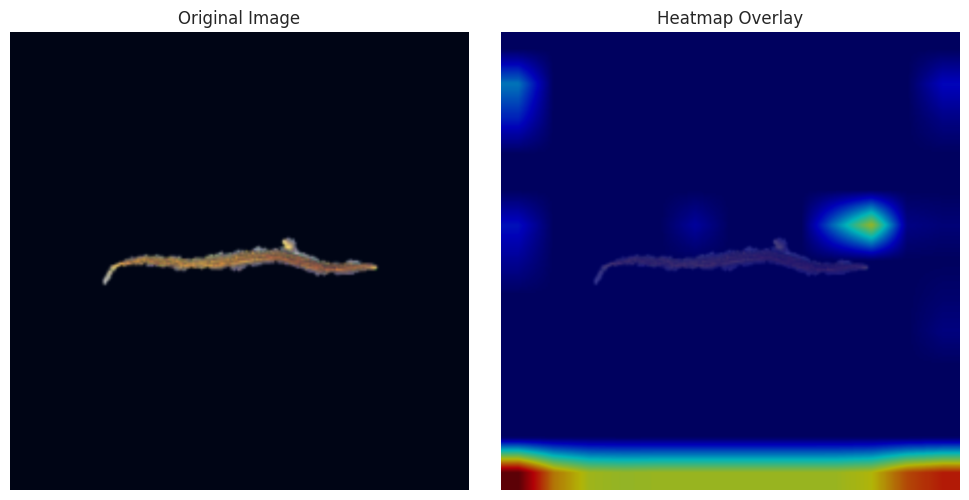

  Generating heatmap for Larvae...
  Predicted label is Larvae!


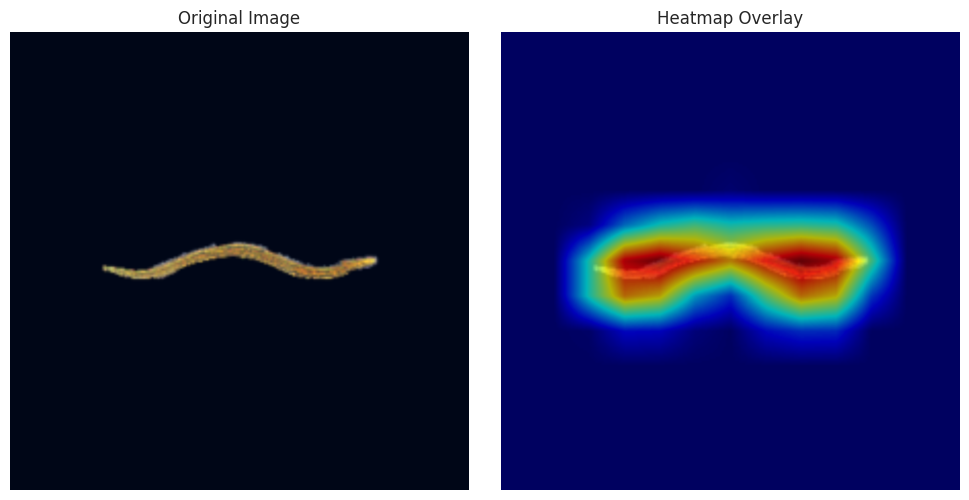

In [16]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.4. CNN2

In [36]:
cnn_2 = PretrainedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    backbone="resnet18",
    use_dropout=True,
    device=device,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [37]:
ckpt_cnn_2 = "weights/larvae-pre-cnn-2.pt"

#### Train MLP

In [38]:
optimizer_cnn_2, scheduler_cnn_2 = build_optimizer_and_scheduler(
    cnn_2,
    optim_config_mlp,
    train_loader_len=len(train_loader),
    total_epochs=50,
)

trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [39]:
cnn_2.freeze_backbone()
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6306 | Val Loss: 0.5474 | Train cohen_kappa_fn: 0.5777 | Val cohen_kappa_fn: 0.6261 | Train f1_fn: 0.9032 | Val f1_fn: 0.9237
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.5007 | Val Loss: 0.4438 | Train cohen_kappa_fn: 0.6818 | Val cohen_kappa_fn: 0.6357 | Train f1_fn: 0.9408 | Val f1_fn: 0.9282
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.4045 | Val Loss: 0.3781 | Train cohen_kappa_fn: 0.7048 | Val cohen_kappa_fn: 0.6613 | Train f1_fn: 0.9465 | Val f1_fn: 0.9367
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.3444 | Val Loss: 0.3135 | Train cohen_kappa_fn: 0.7348 | Val cohen_kappa_fn: 0.6784 | Train f1_fn: 0.9508 | Val f1_fn: 0.9382
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.2987 | Val Loss: 0.2910 | Train cohen_kappa_fn: 0.7280 | Val cohen_kappa_fn: 0.7189 | Train f1_fn: 0.9492 | Val f1_fn: 0.9484
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.2593 | Val Loss: 0.2725 | Train cohen_kappa_fn: 0.7603 | Val cohen_kappa_fn: 0.7106 | Train f1_fn: 0.9564 | Val f1_fn: 0.9464
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.2637 | Val Loss: 0.2588 | Train cohen_kappa_fn: 0.6974 | Val cohen_kappa_fn: 0.6948 | Train f1_fn: 0.9400 | Val f1_fn: 0.9398
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2263 | Val Loss: 0.2481 | Train cohen_kappa_fn: 0.7865 | Val cohen_kappa_fn: 0.7321 | Train f1_fn: 0.9629 | Val f1_fn: 0.9526
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.2282 | Val Loss: 0.2437 | Train cohen_kappa_fn: 0.7211 | Val cohen_kappa_fn: 0.6870 | Train f1_fn: 0.9457 | Val f1_fn: 0.9377
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.2008 | Val Loss: 0.2362 | Train cohen_kappa_fn: 0.7778 | Val cohen_kappa_fn: 0.7625 | Train f1_fn: 0.9613 | Val f1_fn: 0.9583
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.2115 | Val Loss: 0.2288 | Train cohen_kappa_fn: 0.7740 | Val cohen_kappa_fn: 0.7519 | Train f1_fn: 0.9577 | Val f1_fn: 0.9540
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.1886 | Val Loss: 0.2250 | Train cohen_kappa_fn: 0.8165 | Val cohen_kappa_fn: 0.7716 | Train f1_fn: 0.9682 | Val f1_fn: 0.9603
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.2020 | Val Loss: 0.2291 | Train cohen_kappa_fn: 0.7256 | Val cohen_kappa_fn: 0.6870 | Train f1_fn: 0.9454 | Val f1_fn: 0.9377
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1777 | Val Loss: 0.2091 | Train cohen_kappa_fn: 0.7804 | Val cohen_kappa_fn: 0.7841 | Train f1_fn: 0.9612 | Val f1_fn: 0.9621
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.1886 | Val Loss: 0.2224 | Train cohen_kappa_fn: 0.7568 | Val cohen_kappa_fn: 0.7484 | Train f1_fn: 0.9556 | Val f1_fn: 0.9542
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1860 | Val Loss: 0.2095 | Train cohen_kappa_fn: 0.7589 | Val cohen_kappa_fn: 0.7434 | Train f1_fn: 0.9545 | Val f1_fn: 0.9520
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.2092 | Val Loss: 0.2047 | Train cohen_kappa_fn: 0.7455 | Val cohen_kappa_fn: 0.7434 | Train f1_fn: 0.9513 | Val f1_fn: 0.9520
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.1703 | Val Loss: 0.1977 | Train cohen_kappa_fn: 0.7732 | Val cohen_kappa_fn: 0.7660 | Train f1_fn: 0.9596 | Val f1_fn: 0.9582
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.1725 | Val Loss: 0.2047 | Train cohen_kappa_fn: 0.7625 | Val cohen_kappa_fn: 0.7660 | Train f1_fn: 0.9573 | Val f1_fn: 0.9582
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1730 | Val Loss: 0.1985 | Train cohen_kappa_fn: 0.8270 | Val cohen_kappa_fn: 0.8123 | Train f1_fn: 0.9706 | Val f1_fn: 0.9680
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1745 | Val Loss: 0.1990 | Train cohen_kappa_fn: 0.8231 | Val cohen_kappa_fn: 0.7660 | Train f1_fn: 0.9698 | Val f1_fn: 0.9582
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1511 | Val Loss: 0.1966 | Train cohen_kappa_fn: 0.8002 | Val cohen_kappa_fn: 0.7841 | Train f1_fn: 0.9651 | Val f1_fn: 0.9621
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.1449 | Val Loss: 0.1934 | Train cohen_kappa_fn: 0.7940 | Val cohen_kappa_fn: 0.7571 | Train f1_fn: 0.9625 | Val f1_fn: 0.9562
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.1513 | Val Loss: 0.1898 | Train cohen_kappa_fn: 0.7856 | Val cohen_kappa_fn: 0.7398 | Train f1_fn: 0.9610 | Val f1_fn: 0.9522
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.1406 | Val Loss: 0.1880 | Train cohen_kappa_fn: 0.8417 | Val cohen_kappa_fn: 0.7841 | Train f1_fn: 0.9718 | Val f1_fn: 0.9621
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.1489 | Val Loss: 0.2048 | Train cohen_kappa_fn: 0.8576 | Val cohen_kappa_fn: 0.7997 | Train f1_fn: 0.9759 | Val f1_fn: 0.9662
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1417 | Val Loss: 0.1934 | Train cohen_kappa_fn: 0.7740 | Val cohen_kappa_fn: 0.7571 | Train f1_fn: 0.9577 | Val f1_fn: 0.9562
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1583 | Val Loss: 0.1808 | Train cohen_kappa_fn: 0.8134 | Val cohen_kappa_fn: 0.7841 | Train f1_fn: 0.9664 | Val f1_fn: 0.9621
  🔥 New best model saved!


📘 Epoch 29 | Train Loss: 0.1641 | Val Loss: 0.1809 | Train cohen_kappa_fn: 0.7502 | Val cohen_kappa_fn: 0.7484 | Train f1_fn: 0.9520 | Val f1_fn: 0.9542
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.1487 | Val Loss: 0.2082 | Train cohen_kappa_fn: 0.8780 | Val cohen_kappa_fn: 0.8064 | Train f1_fn: 0.9797 | Val f1_fn: 0.9682
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1715 | Val Loss: 0.1742 | Train cohen_kappa_fn: 0.8086 | Val cohen_kappa_fn: 0.7749 | Train f1_fn: 0.9657 | Val f1_fn: 0.9602
  🔥 New best model saved!


📘 Epoch 32 | Train Loss: 0.1136 | Val Loss: 0.2086 | Train cohen_kappa_fn: 0.8499 | Val cohen_kappa_fn: 0.8164 | Train f1_fn: 0.9752 | Val f1_fn: 0.9701
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1452 | Val Loss: 0.1787 | Train cohen_kappa_fn: 0.7964 | Val cohen_kappa_fn: 0.7660 | Train f1_fn: 0.9634 | Val f1_fn: 0.9582
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.1192 | Val Loss: 0.2021 | Train cohen_kappa_fn: 0.8270 | Val cohen_kappa_fn: 0.8164 | Train f1_fn: 0.9706 | Val f1_fn: 0.9701
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.1436 | Val Loss: 0.1983 | Train cohen_kappa_fn: 0.8558 | Val cohen_kappa_fn: 0.8192 | Train f1_fn: 0.9759 | Val f1_fn: 0.9700
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.1362 | Val Loss: 0.1819 | Train cohen_kappa_fn: 0.8466 | Val cohen_kappa_fn: 0.7933 | Train f1_fn: 0.9735 | Val f1_fn: 0.9641
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


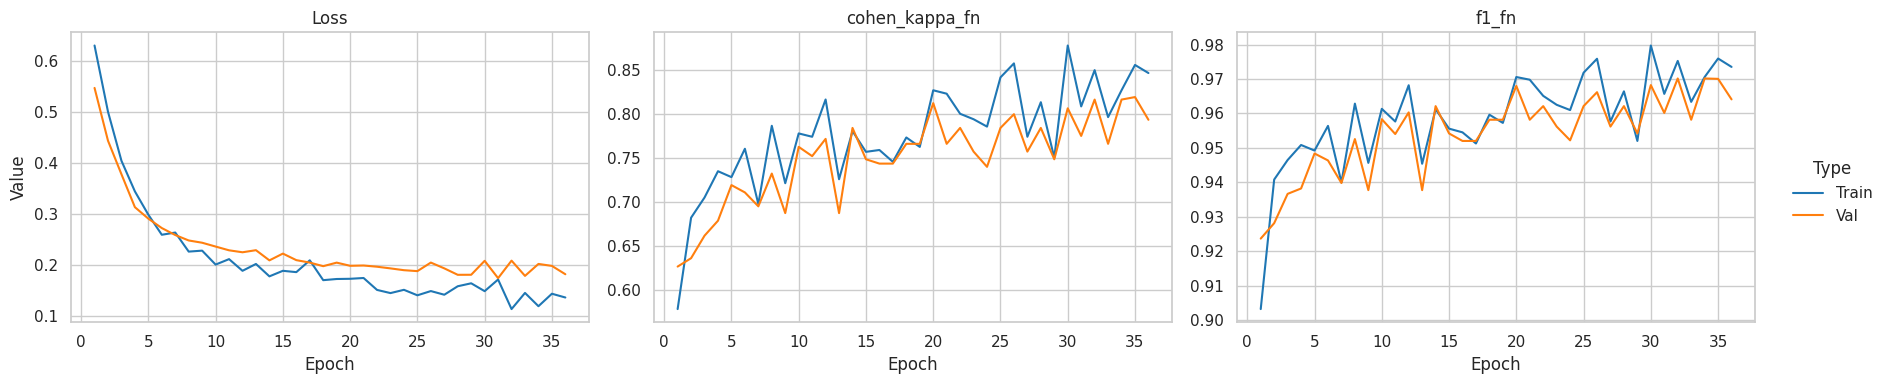

In [40]:
trainer_cnn_2.plot_epochs()

In [41]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1479 | Test cohen_kappa_fn: 0.7445 | Test f1_fn: 0.9512


#### Finetune

In [42]:
optimizer_cnn_2, scheduler_cnn_2 = build_optimizer_and_scheduler(
    cnn_2,
    optim_config_fine,
    train_loader_len=len(train_loader),
    total_epochs=50,
)

trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [43]:
cnn_2.unfreeze_backbone()
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.1550 | Val Loss: 0.2158 | Train cohen_kappa_fn: 0.8681 | Val cohen_kappa_fn: 0.8367 | Train f1_fn: 0.9782 | Val f1_fn: 0.9740
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.0972 | Val Loss: 0.1491 | Train cohen_kappa_fn: 0.8990 | Val cohen_kappa_fn: 0.8707 | Train f1_fn: 0.9835 | Val f1_fn: 0.9796
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.0997 | Val Loss: 0.1463 | Train cohen_kappa_fn: 0.8983 | Val cohen_kappa_fn: 0.9052 | Train f1_fn: 0.9836 | Val f1_fn: 0.9852
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.0830 | Val Loss: 0.1331 | Train cohen_kappa_fn: 0.9125 | Val cohen_kappa_fn: 0.8727 | Train f1_fn: 0.9858 | Val f1_fn: 0.9795
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.0810 | Val Loss: 0.1413 | Train cohen_kappa_fn: 0.9623 | Val cohen_kappa_fn: 0.8727 | Train f1_fn: 0.9940 | Val f1_fn: 0.9795
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.0565 | Val Loss: 0.1095 | Train cohen_kappa_fn: 0.9575 | Val cohen_kappa_fn: 0.8727 | Train f1_fn: 0.9933 | Val f1_fn: 0.9795
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.0622 | Val Loss: 0.1266 | Train cohen_kappa_fn: 0.9764 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9963 | Val f1_fn: 0.9832
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.0404 | Val Loss: 0.1347 | Train cohen_kappa_fn: 0.9671 | Val cohen_kappa_fn: 0.8942 | Train f1_fn: 0.9948 | Val f1_fn: 0.9833
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.0572 | Val Loss: 0.1238 | Train cohen_kappa_fn: 0.9717 | Val cohen_kappa_fn: 0.8565 | Train f1_fn: 0.9955 | Val f1_fn: 0.9755
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.0594 | Val Loss: 0.1173 | Train cohen_kappa_fn: 0.9445 | Val cohen_kappa_fn: 0.8665 | Train f1_fn: 0.9910 | Val f1_fn: 0.9774
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.0394 | Val Loss: 0.1389 | Train cohen_kappa_fn: 0.9905 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9985 | Val f1_fn: 0.9832
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


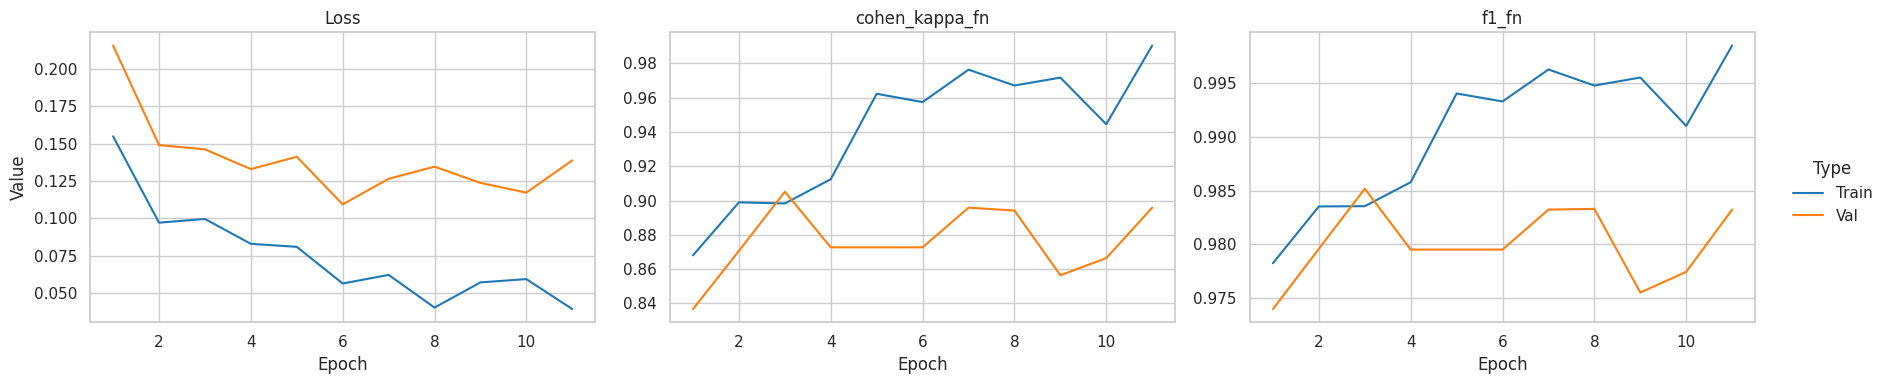

In [44]:
trainer_cnn_2.plot_epochs()

In [45]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.0765 | Test cohen_kappa_fn: 0.8940 | Test f1_fn: 0.9825


#### Visualization

In [46]:
visualizer_2 = Visualizer(model=trainer_cnn_2.model, device=device, labels_map=labels_map)

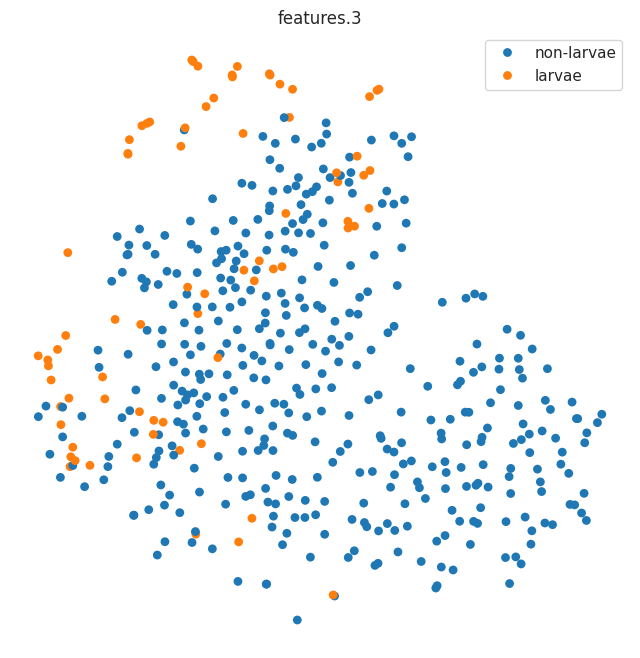

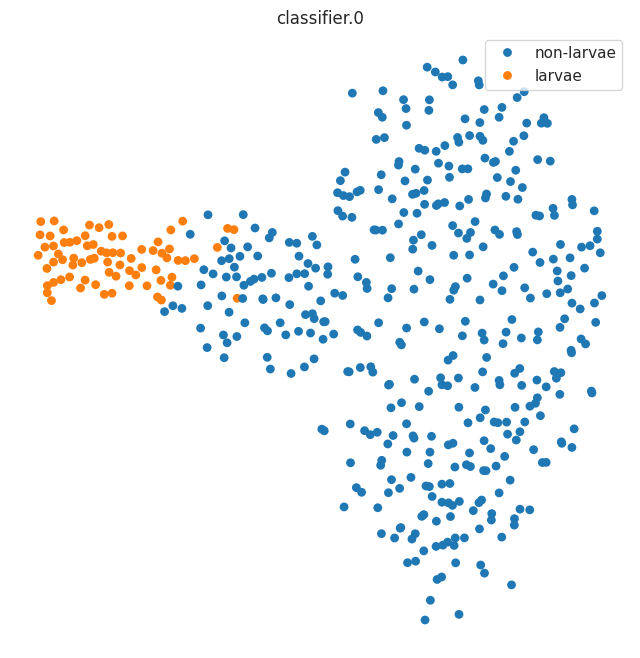

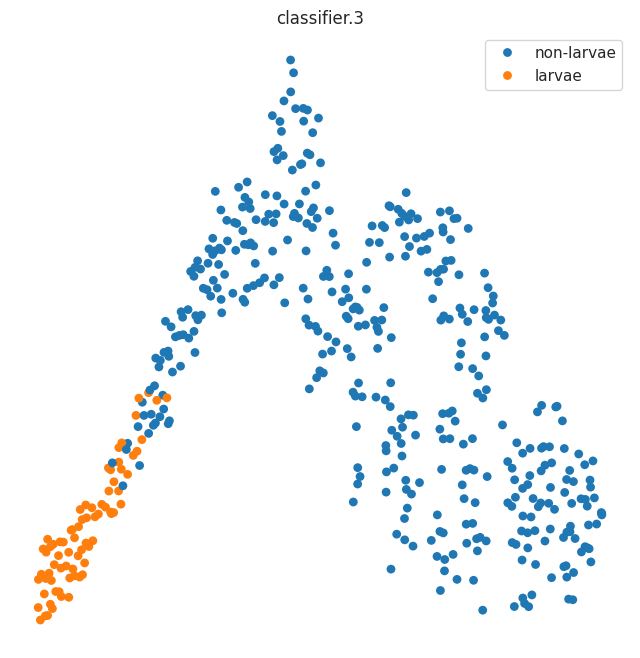

In [47]:
# Display layer representations
visualizer_2.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


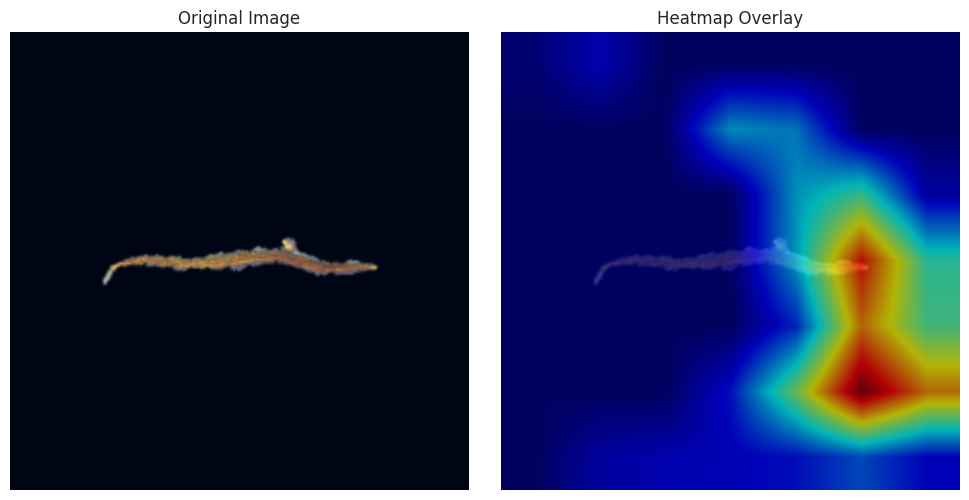

  Generating heatmap for Larvae...
  Predicted label is Larvae!


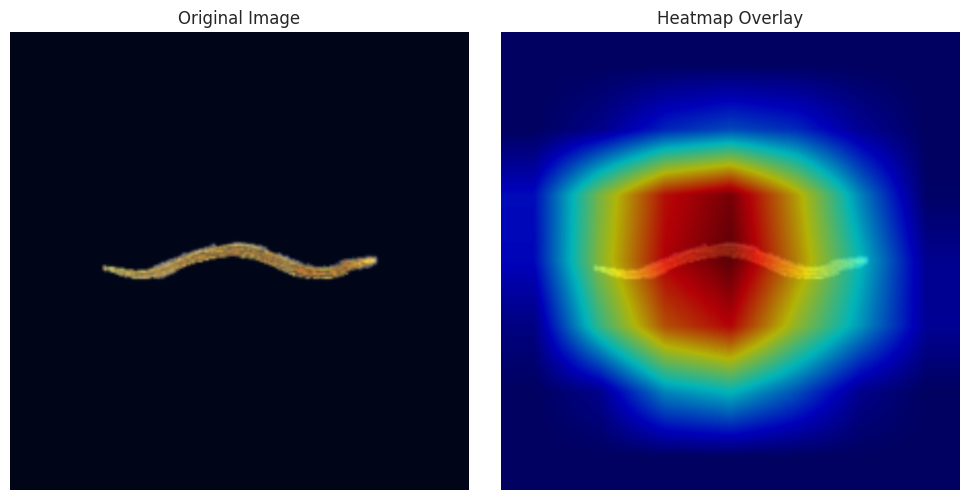

In [48]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break